In [13]:
import torch
from PIL import Image
from diffusers import AutoencoderKL, UNet2DModel, DDIMPipeline, DDIMScheduler
from diffusers.optimization import get_scheduler
from diffusers.training_utils import EMAModel
import math
import requests
from torchvision.transforms import (
    CenterCrop,
    Compose,
    InterpolationMode,
    Normalize,
    RandomHorizontalFlip,
    Resize,
    ToTensor,
    ToPILImage
)
from accelerate import Accelerator
import utils
from tqdm import tqdm
import torch.nn.functional as F


In [3]:
torch.manual_seed(0)

In [4]:
training_config = utils.DiffusionTrainingArgs()

In [5]:
# Load an image of my dog for this example

image_url = "https://i.imgur.com/IJcs4Aa.jpeg"
image = Image.open(requests.get(image_url, stream=True).raw)

In [6]:
# Define the transforms to apply to the image for training
augmentations = utils.get_train_transforms(training_config)

In [7]:
train_image = augmentations(image.convert("RGB"))

In [8]:
teacher = UNet2DModel.from_pretrained("bglick13/minnie-diffusion")


In [17]:
N = 1000
generator = torch.manual_seed(0)


In [18]:
distilled_images = []
for distill_step in range(5):
    print(f"Distill step {distill_step} from {N} -> {N // 2}")
    teacher, distilled_ema, distill_accelrator = utils.distill(teacher, N, train_image, training_config, epochs=1000, batch_size=64)
    N = N // 2
    new_scheduler = DDIMScheduler(num_train_timesteps=N)
    pipeline = DDIMPipeline(
        unet=distill_accelrator.unwrap_model(distilled_ema.averaged_model if training_config.use_ema else teacher),
        scheduler=new_scheduler,
    )

    # run pipeline in inference (sample random noise and denoise)
    images = pipeline(generator=generator, batch_size=training_config.batch_size, output_type="numpy").images

    # denormalize the images and save to tensorboard
    images_processed = (images * 255).round().astype("uint8")
    distilled_images.append(images_processed[0])


Distill step 0 from 1000 -> 500


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s, ema_decay=0.994, loss=0.000163, lr=0, step=1000]


  0%|          | 0/50 [00:00<?, ?it/s]

Distill step 1 from 500 -> 250


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s, ema_decay=0.994, loss=0.000256, lr=0, step=1000]


  0%|          | 0/50 [00:00<?, ?it/s]

Distill step 2 from 250 -> 125


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s, ema_decay=0.994, loss=0.000533, lr=0, step=1000]


  0%|          | 0/50 [00:00<?, ?it/s]

Distill step 3 from 125 -> 62


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s, ema_decay=0.994, loss=0.0014, lr=0, step=1000]


  0%|          | 0/50 [00:00<?, ?it/s]

Distill step 4 from 62 -> 31


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s, ema_decay=0.994, loss=0.0259, lr=0, step=1000]


  0%|          | 0/50 [00:00<?, ?it/s]

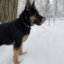

Distilled image 0


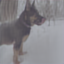

Distilled image 1


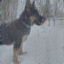

Distilled image 2


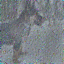

Distilled image 3


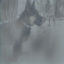

Distilled image 4


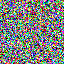

In [19]:
# Display train image for reference
train_image_display = train_image * 0.5 + 0.5
train_image_display = ToPILImage()(train_image_display)
display(train_image_display)

for i, image in enumerate(distilled_images):
    print(f"Distilled image {i}")
    display(Image.fromarray(image))
    Image.fromarray(image).save(f"distilled_{i}.png")

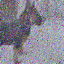

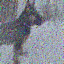

In [12]:
display(Image.fromarray(images_processed[0]))
display(Image.fromarray(images_processed[1]))